# Import Libraries

In [113]:
%%capture
%pip install transformers
%pip install Sastrawi
%pip install emoji
%pip install symspellpy
%pip install langdetect

In [114]:
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
from IPython.display import display, HTML

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from wordcloud import WordCloud


# NLP
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import emoji
from symspellpy import SymSpell, Verbosity
from langdetect import detect, LangDetectException
from collections import Counter

In [115]:
# Inisiasi & Konfigurasi
tqdm.pandas()
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use('seaborn-v0_8-whitegrid')

# Data Loading

In [116]:
# Membaca dataset Pemilu dan BBM
pemilu_df = pd.read_csv("../data/pemilu_raw.csv")
bbm_df = pd.read_csv("../data/kenaikan_bbm_raw.csv")

# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,Hasil,Tweet,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,barusan liat tulisan di belakang truk rela inj...,NaN,NaN,NaN
1,0,her itu lho miss kevin sama keven rebutan gimb...,NaN,NaN,NaN
2,0,iya rep gatau aku masih kelas 4 sd ehh di block,NaN,NaN,NaN
3,0,aku mohon tepatilah janjimu penantiancintaeps19,NaN,NaN,NaN
4,0,bukan beria nk kahwin sbb gatal celah kangkang...,NaN,NaN,NaN


BBM DataFrame:


,sentimen,text
0,NETRAL,@tanyarlfes Gaada bukti tapi dulu gw kalo nget...
1,NETRAL,@pcogovph Kayang kaya talaga paikutin ni Digon...
2,NEGATIF,@kpktemananies @musniumar Bajingany di mna om ...
3,NEGATIF,@m8deman @lovelyb1e Km yg ngomong ini pasti kr...
4,NEGATIF,@OposisiCerdas @venasantika Gaji besar bukanny...


In [117]:
# Melakukan penghapusan kolom yang tidak digunakan
pemilu_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace=True)

# Mengganti representasi nilai kolom sentimen
pemilu_df['Hasil'] = pemilu_df['Hasil'].replace({0: 'neutral', 1: 'positive', -1: 'negative'})
bbm_df['sentimen'] = bbm_df['sentimen'].replace({"NETRAL": 'neutral', "POSITIF": 'positive', "NEGATIF": 'negative'})

# Mengganti nama kolom untuk kemudahan proses data
pemilu_df = pemilu_df.rename(columns={"Tweet": "text", "Hasil": "sentiment"})
bbm_df = bbm_df.rename(columns={"sentimen": 'sentiment'})

In [118]:
# Menampilkan beberapa baris dari dataframe
print("Pemilu DataFrame:")
display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

Pemilu DataFrame:


,sentiment,text
0,neutral,barusan liat tulisan di belakang truk rela inj...
1,neutral,her itu lho miss kevin sama keven rebutan gimb...
2,neutral,iya rep gatau aku masih kelas 4 sd ehh di block
3,neutral,aku mohon tepatilah janjimu penantiancintaeps19
4,neutral,bukan beria nk kahwin sbb gatal celah kangkang...


BBM DataFrame:


,sentiment,text
0,neutral,@tanyarlfes Gaada bukti tapi dulu gw kalo nget...
1,neutral,@pcogovph Kayang kaya talaga paikutin ni Digon...
2,negative,@kpktemananies @musniumar Bajingany di mna om ...
3,negative,@m8deman @lovelyb1e Km yg ngomong ini pasti kr...
4,negative,@OposisiCerdas @venasantika Gaji besar bukanny...


# Data Visualization

In [119]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42692 entries, 0 to 42691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  42692 non-null  object
 1   text       42692 non-null  object
dtypes: object(2)
memory usage: 667.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7529 entries, 0 to 7528
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  7529 non-null   object
 1   text       7529 non-null   object
dtypes: object(2)
memory usage: 117.8+ KB


In [120]:
def create_donut_plot(sizes, ax, title):
    colors = sns.color_palette('pastel')[0:len(sizes)]
    
    ax.pie(sizes, 
           colors=colors, 
           labels=sizes.index, 
           autopct='%.1f%%', 
           startangle=90, 
           pctdistance=0.85, 
           wedgeprops=dict(width=0.4, edgecolor='w'),
           textprops={'fontsize': 12, 'fontweight': 'bold'})

    # Lingkaran tengah untuk efek donat
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax.add_artist(centre_circle)
    
    ax.set_title(title, pad=20)
    plt.axis('equal')

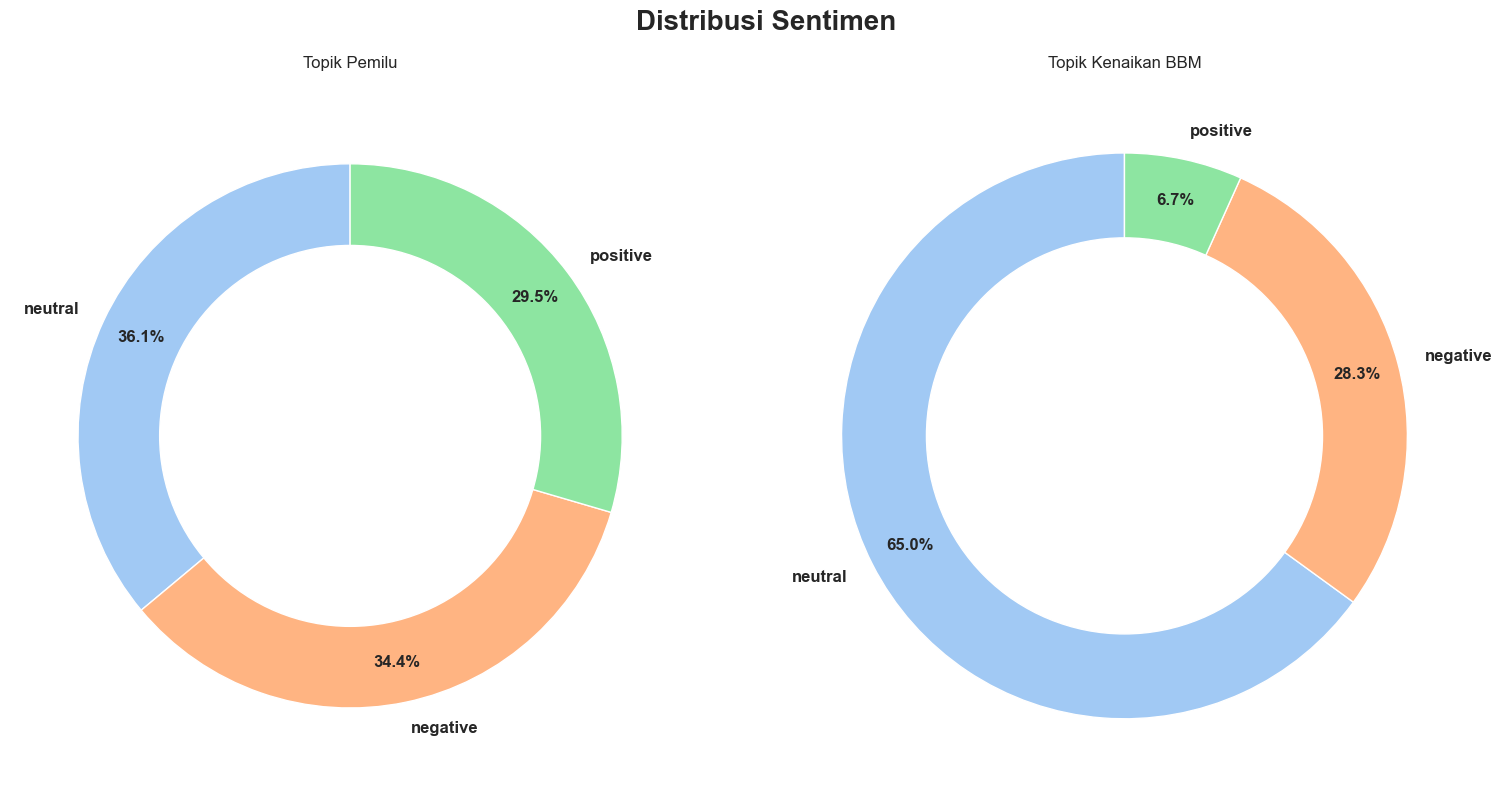

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Distribusi Sentimen', fontsize=20, fontweight='bold')

# Plot untuk data Pemilu
create_donut_plot(pemilu_df.sentiment.value_counts(), ax1, 'Topik Pemilu')

# Plot untuk data BBM
create_donut_plot(bbm_df.sentiment.value_counts(), ax2, 'Topik Kenaikan BBM')

plt.tight_layout()
plt.show()

In [122]:
def analyze_word_frequency(df, text_column='text', top_n=20):
    corpus = ' '.join(df[text_column].dropna().astype(str).tolist())
    corpus_cleaned = re.sub(r'[^a-zA-Z\s]', '', corpus).lower()
    
    tokens = corpus_cleaned.split()
    
    # Lanjutkan dengan hitung frekuensi
    freq = FreqDist(tokens)
    
    freq_df = pd.DataFrame(freq.most_common(top_n), columns=['word', 'freq'])
    return freq_df, corpus_cleaned


In [123]:
pemilu_freq_df, pemilu_corpus_for_cloud = analyze_word_frequency(pemilu_df, top_n=20)
bbm_freq_df, bbm_corpus_for_cloud = analyze_word_frequency(bbm_df, top_n=20)

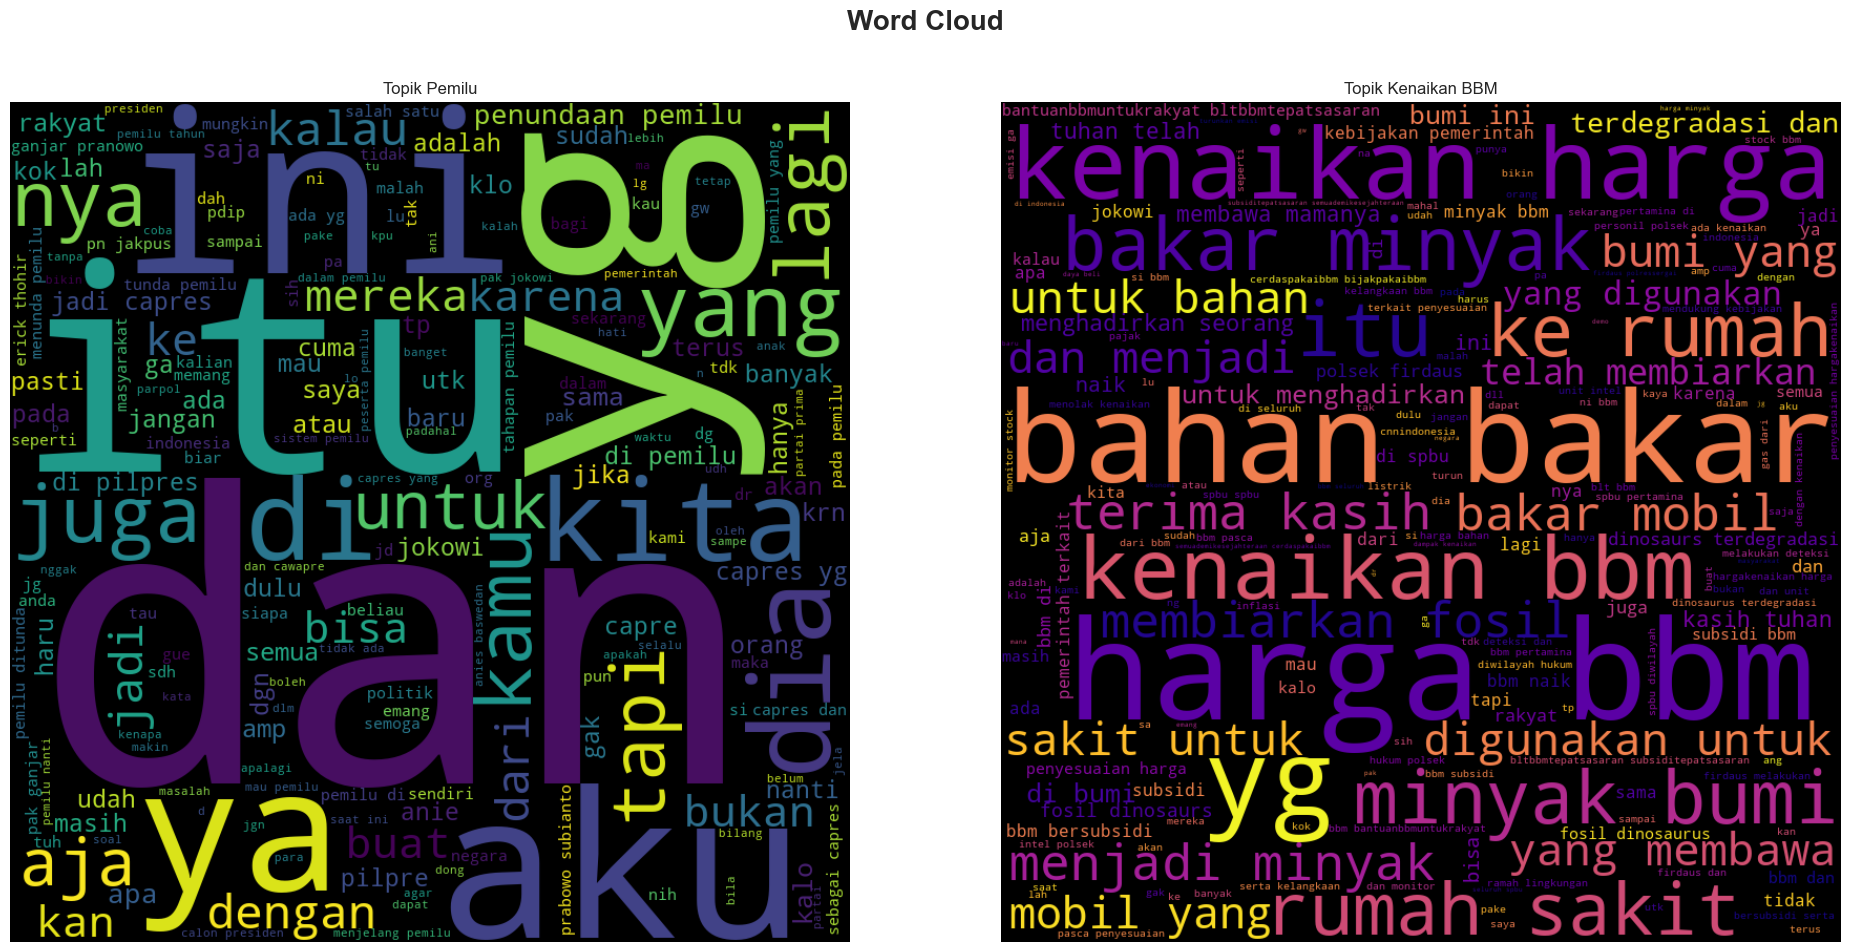

In [124]:
# Visualisasi Word Cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Word Cloud', fontsize=20, fontweight='bold')

wordcloud_pemilu = WordCloud(width=800, height=800, background_color='black', colormap='viridis').generate(pemilu_corpus_for_cloud)
ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
ax1.set_title('Topik Pemilu')
ax1.axis("off")

wordcloud_bbm = WordCloud(width=800, height=800, background_color='black', colormap='plasma').generate(bbm_corpus_for_cloud)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.set_title('Topik Kenaikan BBM')
ax2.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Filtering

In [125]:
keywords_pemerintahan = [
    # Lembaga & Jabatan
    'pemerintah', 'presiden', 'wapres', 'wakil presiden', 'menteri', 'kementerian',
    'dpr', 'mpr', 'dewan', 'gubernur', 'bupati', 'walikota', 'pemda', 'pemprov',
    'pemkot', 'pemkab', 'istana', 'negara', 'republik', 'birokrasi', 'aparat',
    
    # Proses Politik
    'pemilu', 'pilpres', 'pilkada', 'pileg', 'capres', 'cawapres', 'partai',
    'koalisi', 'oposisi', 'kampanye', 'debat', 'suara', 'coblos', 'tps',
    'kpu', 'bawaslu', 'quick count', 'real count', 'konstitusi', 'uud',
    
    # Istilah Politik
    'politik', 'demokrasi', 'rezim', 'kekuasaan', 'jabatan', 'kepemimpinan',
    'pencitraan', 'elektabilitas', 'survei', 'dinasti politik'
]

keywords_ekonomi_kebijakan = [
    # Kebijakan Ekonomi
    'bbm', 'subsidi', 'bensin', 'solar', 'pertalite', 'pertamax', 'pertamina',
    'harga naik', 'kenaikan harga', 'sembako', 'pangan', 'inflasi', 'ekonomi',
    'listrik', 'pln', 'tarif', 'pajak', 'ppn', 'utang negara', 'anggaran', 'apbn',
    'impor', 'ekspor', 'investasi', 'umkm',
    
    # Kebijakan Sosial & Pembangunan
    'infrastruktur', 'jalan tol', 'bendungan', 'proyek', 'pembangunan', 'ikn',
    'kesehatan', 'bpjs', 'rumah sakit', 'pendidikan', 'kurikulum', 'lapangan kerja',
    'blt', 'bantuan sosial', 'bansos', 'hukum', 'keadilan', 'uu', 'undang-undang'
]

keywords_tokoh_partai = [
    # Tokoh Utama
    'jokowi', 'joko widodo', 'prabowo', 'gibran', 'anies', 'baswedan', 'ganjar',
    'pranowo', 'mahfud', 'mahfudmd', 'cak imin', 'muhaimin',
    
    # Tokoh Lain yang Sering Disebut
    'sby', 'yudhoyono', 'megawati', 'puan', 'ahy', 'erick thohir', 'sandiaga',
    'ridwan kamil', 'luhut', 'sri mulyani',
    
    # Partai Besar
    'pdip', 'gerindra', 'golkar', 'nasdem', 'pkb', 'pks', 'demokrat', 'pan', 'ppp'
]

keywords_gaul_isu = [
    # Istilah Informal
    'cebong', 'kampret', 'kadrun', 'buzzer', 'oligarki', 'rezim',
    
    # Isu Sosial
    'korupsi', 'kkn', 'suap', 'pelanggaran ham', 'ketidakadilan',
    'kemiskinan', 'pengangguran'
]

In [126]:
# Gabungkan semua daftar menjadi satu
all_keywords = (
    keywords_pemerintahan +
    keywords_ekonomi_kebijakan +
    keywords_tokoh_partai +
    keywords_gaul_isu
)

all_keywords = list(set(all_keywords))

print(f"Total kata kunci untuk filter: {len(all_keywords)}")

pattern = r'\b(' + '|'.join(all_keywords) + r')\b'


pemilu_df_relevant = pemilu_df[pemilu_df['text'].str.contains(pattern, case=False, na=False)].copy()

print(f"\nJumlah data awal: {len(pemilu_df)}")
print(f"Jumlah data setelah filter relevansi: {len(pemilu_df_relevant)}")

Total kata kunci untuk filter: 138


C:\Users\admin\AppData\Local\Temp\ipykernel_25732\3925875631.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pemilu_df_relevant = pemilu_df[pemilu_df['text'].str.contains(pattern, case=False, na=False)].copy()



Jumlah data awal: 42692
Jumlah data setelah filter relevansi: 30482


In [127]:
keywords_inti = [
    'bbm naik', 'kenaikan bbm', 'harga bbm', 'bbm mahal', 'turunkan bbm',
    'subsidi bbm', 'bbm subsidi', 'bbm bersubsidi',
    'pertalite', 'pertamax', 'solar', 'bensin',
    'spbu', 'pom bensin',
    'harga minyak', 'minyak dunia'
]

keywords_kebijakan = [
    'pertamina', 'bph migas', 'kementerian esdm', 'pemerintah', 'kebijakan',
    'subsidi', 'penyesuaian harga', 'harga eceran', 'kuota bbm',
    'impor bbm', 'ketahanan energi', 'bbm ilegal', 'penimbunan bbm'
]

keywords_dampak = [
    'harga naik', 'inflasi', 'tarif listrik', 'gas lpg', 'sembako',
    'biaya transportasi', 'ongkos', 'daya beli', 'rakyat kecil',
    'petani', 'nelayan', 'umkm', 'ojol', 'sopir angkot',
    'demo', 'unjuk rasa'
]

keywords_konteks_lain = [
    'kendaraan listrik', 'mobil listrik', 'motor listrik', 'konversi',
    'bahan bakar minyak', 'bahan bakar nabati', 'biofuel', 'bioetanol'
]

In [128]:
print(f"Total kata kunci untuk filter: {len(all_keywords)}")

pattern = '|'.join(all_keywords)

print(f"Jumlah data awal (BBM - Bahasa Indonesia): {len(bbm_df)}")

bbm_df_relevant = bbm_df[bbm_df['text'].str.contains(pattern, case=False, na=False)].copy()
bbm_df_relevant.reset_index(drop=True, inplace=True)

print(f"Jumlah data setelah filter relevansi: {len(bbm_df_relevant)}")

Total kata kunci untuk filter: 138
Jumlah data awal (BBM - Bahasa Indonesia): 7529
Jumlah data setelah filter relevansi: 7291


# Data Preprocessing

In [129]:
pemilu_df = pemilu_df_relevant.copy()
bbm_df = bbm_df_relevant.copy()

In [130]:
# 1. Duplicate data
print(f"Data duplikat di Pemilu DF: {pemilu_df.duplicated().sum()}")
pemilu_df.drop_duplicates(inplace=True)
print(f"Data duplikat di BBM DF: {bbm_df.duplicated().sum()}")
bbm_df.drop_duplicates(inplace=True)
print("Data duplikat telah dihapus.")

Data duplikat di Pemilu DF: 21
Data duplikat di BBM DF: 433
Data duplikat telah dihapus.


In [131]:
# Ukuran baris, kolom
pemilu_df.shape, bbm_df.shape

((30461, 2), (6858, 2))

In [132]:
# 2. repeated characters
def clean_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [133]:
# 3. Cek Bahasa
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

In [134]:
pemilu_df['language'] = pemilu_df['text'].progress_apply(detect_language)
pemilu_df_id = pemilu_df[pemilu_df['language'] == 'id'].copy()

pemilu_df_id.reset_index(drop=True, inplace=True)
pemilu_df_id.drop('language', axis=1, inplace=True)

print(f"Dataset Pemilu sebelum filter: {len(pemilu_df)} baris Bahasa Indonesia. ({len(pemilu_df) - len(pemilu_df_id)} baris dibuang)")
print(f"Dataset Pemilu setelah filter: {len(pemilu_df_id)} baris Bahasa Indonesia.")

100%|██████████| 30461/30461 [01:08<00:00, 446.50it/s]

Dataset Pemilu sebelum filter: 30461 baris Bahasa Indonesia. (913 baris dibuang)
Dataset Pemilu setelah filter: 29548 baris Bahasa Indonesia.


In [135]:
bbm_df['language'] = bbm_df['text'].progress_apply(detect_language)
bbm_df_id = bbm_df[bbm_df['language'] == 'id'].copy()

bbm_df_id.drop('language', axis=1, inplace=True)
bbm_df_id.reset_index(drop=True, inplace=True)

print(f"Dataset BBM sebelum filter: {len(bbm_df)} baris Bahasa Indonesia. ({len(bbm_df) - len(bbm_df_id)} baris dibuang)")
print(f"Dataset BBM setelah filter: {len(bbm_df_id)} baris Bahasa Indonesia.")

100%|██████████| 6858/6858 [00:13<00:00, 525.00it/s]

Dataset BBM sebelum filter: 6858 baris Bahasa Indonesia. (1022 baris dibuang)
Dataset BBM setelah filter: 5836 baris Bahasa Indonesia.


In [136]:
campaign_hashtags = [
    'bantuanbbmuntukrakyat', 'bltbbmtepatsasaran', 'subsiditepatsasaran',
    'cerdaspakaibbm', 'bijakpakaibbm', 'semuademikesejahteraan', 
    'bltbbmbantumasyarakat', 'bansosbbmringankanrakyat', 
    'sukseskankebijakanpemerintah', 'subsidiberkeadilanuntukmasadepan',
    'pkspembelarakyat', 'polusiknalpottransportasi', 'pakaimolis', 'pakaimolisyuk',

    'mendingprabow', 'terusmajubersamaprabowo'
]
pattern_to_remove = r'\b(' + '|'.join(campaign_hashtags) + r')\b'

In [137]:
# 4. Clean noise text
def clean_text(text):
    text = text.lower()                                     
    text = re.sub(r'\n', ' ', text)                         
    text = emoji.demojize(text)                             
    text = re.sub(':[A-Za-z_-]+:', ' ', text)               
    text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)     
    text = re.sub(r'http\S+|www\S+', '', text)               
    text = re.sub(r'@[^\s]+', '', text)                      
    text = re.sub(r'#(\S+)', r'\1', text)                   
    text = re.sub('[^a-zA-Z\s]+', ' ', text)            
    text = re.sub(pattern_to_remove, '', text, flags=re.IGNORECASE)   
    text = clean_repeated_chars(text)                      
    text = re.sub(' +', ' ', text).strip()                 
    return text

In [150]:
from symspellpy import SymSpell

In [151]:
# Inisiasi komponen
def load_slang_dict(file_path):
    slang_dict = {}
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if ':' in line:
                    key, value = line.strip().split(':', 1)
                    slang_dict[key.strip()] = value.strip()
    except FileNotFoundError:
        print(f"File kamus slang tidak ditemukan di: {file_path}")
    return slang_dict

slang_dict = load_slang_dict('../data/slang_dict.txt')

stopword_factory = StopWordRemoverFactory()
stop_words = stopword_factory.get_stop_words()
negation_words = ['tidak', 'bukan', 'tak', 'jangan', 'gak', 'nggak', 'ngga', 'nggak', 'ga', 'gak', 'ngga', 'ngga', 'enggak', 'tanpa']
stop_words_final = [word for word in stop_words if word not in negation_words]

kamus_path = "../data/kamus_frekuensi.txt"
kamus_pemilu_path = "../data/kamus_custom_pemilu.txt"
kamus_bbm_path = "../data/kamus_custom_bbm.txt"


semua_berhasil = True

kamus_list = [
    {"name": "Umum", "path": kamus_path},
    {"name": "Pemilu", "path": kamus_pemilu_path},
    {"name": "BBM", "path": kamus_bbm_path}
]

semua_berhasil = True
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

for kamus in kamus_list:
    try:
        if sym_spell.load_dictionary(kamus['path'], term_index=0, count_index=1, separator=" ", encoding="utf-8"):
            print("Berhasil dimuat")
        else:
            semua_berhasil = False
            
    except FileNotFoundError:
        semua_berhasil = False


Berhasil dimuat
Berhasil dimuat
Berhasil dimuat


In [152]:
# 5. ubah ejaan slang
def normalize_slang(text, slang_dict):
    words = text.split()
    replaced_words = []
    normalized_words = []
    
    for word in words:
        normalized_word = slang_dict.get(word, word)
        normalized_words.append(normalized_word)
        if word != normalized_word:
            replaced_words.append(f"'{word}' -> '{normalized_word}'")
            
    normalized_text = ' '.join(normalized_words)
    
    return normalized_text, replaced_words

In [153]:
# 6. Koreksi ejaan
def correct_spell(text, sym_spell_instance):
    if not sym_spell_instance:
        return text, []
        
    words = text.split()
    corrected_words_log = []
    corrected_sentence_words = []

    for word in words:
        suggestions = sym_spell_instance.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        if suggestions:
            corrected_word = suggestions[0].term
            corrected_sentence_words.append(corrected_word)
            if word != corrected_word:
                corrected_words_log.append(f"'{word}' -> '{corrected_word}'")
        else:
            corrected_sentence_words.append(word)
            
    corrected_text = ' '.join(corrected_sentence_words)
    
    return corrected_text, corrected_words_log

In [154]:
def preprocess_pipeline(text, use_spell_checker=True):
    logs = {
        'slang_replaced': [],
        'spelling_corrected': [],
        'words_removed': []
    }
    
    processed_text = clean_text(str(text))
    
    words = processed_text.split()
    normalized_words = []
    for word in words:
        normalized_word = slang_dict.get(word, word)
        normalized_words.append(normalized_word)
        if word != normalized_word:
            logs['slang_replaced'].append(f"'{word}'->'{normalized_word}'")
    processed_text = ' '.join(normalized_words)
    
    if use_spell_checker and sym_spell:
        words = processed_text.split()
        corrected_sentence_words = []
        for word in words:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
            if suggestions:
                corrected_word = suggestions[0].term
                corrected_sentence_words.append(corrected_word)
                if word != corrected_word:
                    logs['spelling_corrected'].append(f"'{word}'->'{corrected_word}'")
            else:
                corrected_sentence_words.append(word)
        processed_text = ' '.join(corrected_sentence_words)
        
    tokens = word_tokenize(processed_text)
    final_tokens = []
    for token in tokens:
        if token in stop_words_final:
            logs['words_removed'].append(token)
        else:
            final_tokens.append(token)
    
    final_text = ' '.join(final_tokens)
    
    return {
        'final_text': final_text,
        'logs': logs
    }

In [155]:
pemilu_df_id['processing_results'] = pemilu_df_id['text'].progress_apply(
    lambda x: preprocess_pipeline(x, use_spell_checker=True)
)


bbm_df_id['processing_results'] = bbm_df_id['text'].progress_apply(
    lambda x: preprocess_pipeline(x, use_spell_checker=True)
)

# Inisialisasi list untuk mengumpulkan semua log dari seluruh dataset
all_slang_log = []
all_spell_log = []
all_stopword_log = []

# Loop melalui kolom hasil untuk mengumpulkan log
for result in pemilu_df_id['processing_results']:
    logs = result['logs']
    all_slang_log.extend(logs['slang_replaced'])
    all_spell_log.extend(logs['spelling_corrected'])
    all_stopword_log.extend(logs['words_removed'])

100%|██████████| 5836/5836 [00:01<00:00, 3876.98it/s]


In [156]:
slang_counts = Counter(all_slang_log)
print("\n--- Top 20 Penggantian Slang yang Paling Sering Dilakukan ---")
for replacement, count in slang_counts.most_common(20):
    print(f"- {replacement}: {count} kali")

spell_counts = Counter(all_spell_log)
print("\n--- Top 20 Koreksi Ejaan yang Paling Sering Dilakukan ---")
for correction, count in spell_counts.most_common(20):
    print(f"- {correction}: {count} kali")

stopword_counts = Counter(all_stopword_log)
print("\n--- Top 20 Stopwords yang Paling Sering Dihapus ---")
for word, count in stopword_counts.most_common(20):
    print(f"- '{word}': {count} kali")



--- Top 20 Penggantian Slang yang Paling Sering Dilakukan ---
- 'pemilu'->'pemilihan umum': 19337 kali
- 'yg'->'yang': 9576 kali
- 'ya'->'iya': 2341 kali
- 'aja'->'saja': 2282 kali
- 'gak'->'tidak': 2058 kali
- 'ga'->'tidak': 1652 kali
- 'kalo'->'kalau': 1273 kali
- 'tdk'->'tidak': 1234 kali
- 'utk'->'untuk': 1076 kali
- 'udah'->'sudah': 1055 kali
- 'jd'->'jadi': 1044 kali
- 'dgn'->'dengan': 1006 kali
- 'klo'->'kalau': 913 kali
- 'sdh'->'sudah': 851 kali
- 'tak'->'tidak': 758 kali
- 'krn'->'karena': 709 kali
- 'tau'->'tahu': 614 kali
- 'tp'->'tapi': 612 kali
- 'malah'->'bahkan': 582 kali
- 'dlm'->'dalam': 541 kali

--- Top 20 Koreksi Ejaan yang Paling Sering Dilakukan ---
- 'Cuma'->'cuma': 105 kali
- 'narkotika,'->'narkotika': 84 kali
- 'psikotropika,'->'psikotropika': 84 kali
- 'kriti'->'kritis': 71 kali
- 'langsung,'->'langsung': 26 kali
- 'umum,'->'umum': 26 kali
- 'bebas,'->'bebas': 26 kali
- 'xf'->'of': 15 kali
- 'wkk'->'wkwk': 11 kali
- 'xe'->'ke': 9 kali
- 'way,'->'way': 9 kali

In [157]:
pemilu_df_id['text_cleaned'] = pemilu_df_id['processing_results'].apply(lambda x: x['final_text'])
bbm_df_id['text_cleaned'] = bbm_df_id['processing_results'].apply(lambda x: x['final_text'])

In [158]:
def finalize_df(df):
    if 'text_cleaned' not in df.columns:
        print("Error: Kolom 'text_cleaned' tidak ditemukan.")
        return None
    
    df_final = df[['text_cleaned', 'sentiment']].copy()
    df_final.rename(columns={'text_cleaned': 'text'}, inplace=True)
    
    df_final['text'] = df_final['text'].replace('', np.nan)
    df_final.dropna(subset=['text'], inplace=True)
    
    return df_final.reset_index(drop=True)

In [159]:
pemilu_final_df = finalize_df(pemilu_df_id)
bbm_final_df = finalize_df(bbm_df_id)

# Last Filter 

In [160]:
keywords_pemerintahan = [
    # Lembaga & Jabatan
    'pemerintah', 'presiden', 'wapres', 'wakil presiden', 'menteri', 'kementerian',
    'dpr', 'mpr', 'dewan', 'gubernur', 'bupati', 'walikota', 'pemda', 'pemprov',
    'pemkot', 'pemkab', 'istana', 'negara', 'republik', 'birokrasi', 'aparat',
    
    # Proses Politik
    'pemilu', 'pilpres', 'pilkada', 'pileg', 'capres', 'cawapres', 'partai',
    'koalisi', 'oposisi', 'kampanye', 'debat', 'suara', 'coblos', 'tps',
    'kpu', 'bawaslu', 'quick count', 'real count', 'konstitusi', 'uud',
    
    # Istilah Politik
    'politik', 'demokrasi', 'rezim', 'kekuasaan', 'jabatan', 'kepemimpinan',
    'pencitraan', 'elektabilitas', 'survei', 'dinasti politik'
]

keywords_ekonomi_kebijakan = [
    # Kebijakan Ekonomi
    'bbm', 'subsidi', 'bensin', 'solar', 'pertalite', 'pertamax', 'pertamina',
    'harga naik', 'kenaikan harga', 'sembako', 'pangan', 'inflasi', 'ekonomi',
    'listrik', 'pln', 'tarif', 'pajak', 'ppn', 'utang negara', 'anggaran', 'apbn',
    'impor', 'ekspor', 'investasi', 'umkm',
    
    # Kebijakan Sosial & Pembangunan
    'infrastruktur', 'jalan tol', 'bendungan', 'proyek', 'pembangunan', 'ikn',
    'kesehatan', 'bpjs', 'rumah sakit', 'pendidikan', 'kurikulum', 'lapangan kerja',
    'blt', 'bantuan sosial', 'bansos', 'hukum', 'keadilan', 'uu', 'undang-undang'
]

keywords_tokoh_partai = [
    # Tokoh Utama
    'jokowi', 'joko widodo', 'prabowo', 'gibran', 'anies', 'baswedan', 'ganjar',
    'pranowo', 'mahfud', 'mahfudmd', 'cak imin', 'muhaimin',
    
    # Tokoh Lain yang Sering Disebut
    'sby', 'yudhoyono', 'megawati', 'puan', 'ahy', 'erick thohir', 'sandiaga',
    'ridwan kamil', 'luhut', 'sri mulyani',
    
    # Partai Besar
    'pdip', 'gerindra', 'golkar', 'nasdem', 'pkb', 'pks', 'demokrat', 'pan', 'ppp'
]

keywords_gaul_isu = [
    # Istilah Informal
    'cebong', 'kampret', 'kadrun', 'buzzer', 'oligarki', 'rezim',
    
    # Isu Sosial
    'korupsi', 'kkn', 'suap', 'pelanggaran ham', 'ketidakadilan',
    'kemiskinan', 'pengangguran'
]

In [161]:
# Gabungkan semua daftar menjadi satu
all_keywords = (
    keywords_pemerintahan +
    keywords_ekonomi_kebijakan +
    keywords_tokoh_partai +
    keywords_gaul_isu
)

all_keywords = list(set(all_keywords))

print(f"Total kata kunci untuk filter: {len(all_keywords)}")

pattern = r'\b(' + '|'.join(all_keywords) + r')\b'


pemilu_df_relevant = pemilu_final_df[pemilu_final_df['text'].str.contains(pattern, case=False, na=False)].copy()

print(f"\nJumlah data awal: {len(pemilu_final_df)}")
print(f"Jumlah data setelah filter relevansi: {len(pemilu_df_relevant)}")

Total kata kunci untuk filter: 138


C:\Users\admin\AppData\Local\Temp\ipykernel_25732\2854671914.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pemilu_df_relevant = pemilu_final_df[pemilu_final_df['text'].str.contains(pattern, case=False, na=False)].copy()



Jumlah data awal: 29548
Jumlah data setelah filter relevansi: 22205


In [162]:
keywords_inti = [
    'bbm naik', 'kenaikan bbm', 'harga bbm', 'bbm mahal', 'turunkan bbm',
    'subsidi bbm', 'bbm subsidi', 'bbm bersubsidi',
    'pertalite', 'pertamax', 'solar', 'bensin',
    'spbu', 'pom bensin',
    'harga minyak', 'minyak dunia'
]
    
keywords_kebijakan = [
    'pertamina', 'bph migas', 'kementerian esdm', 'pemerintah', 'kebijakan',
    'subsidi', 'penyesuaian harga', 'harga eceran', 'kuota bbm',
    'impor bbm', 'ketahanan energi', 'bbm ilegal', 'penimbunan bbm'
]

keywords_dampak = [
    'harga naik', 'inflasi', 'tarif listrik', 'gas lpg', 'sembako',
    'biaya transportasi', 'ongkos', 'daya beli', 'rakyat kecil',
    'petani', 'nelayan', 'umkm', 'ojol', 'sopir angkot',
    'demo', 'unjuk rasa'
]

keywords_konteks_lain = [
    'kendaraan listrik', 'mobil listrik', 'motor listrik', 'konversi',
    'bahan bakar minyak', 'bahan bakar nabati', 'biofuel', 'bioetanol'
]

In [163]:
print(f"Total kata kunci untuk filter: {len(all_keywords)}")

pattern = '|'.join(all_keywords)

bbm_df_relevant = bbm_final_df[bbm_final_df['text'].str.contains(pattern, case=False, na=False)].copy()
bbm_df_relevant.reset_index(drop=True, inplace=True)

print(f"\nJumlah data awal: {len(bbm_final_df)}")
print(f"Jumlah data setelah filter relevansi: {len(bbm_df_relevant)}")

Total kata kunci untuk filter: 138

Jumlah data awal: 5835
Jumlah data setelah filter relevansi: 5756


In [164]:
# Menyimpan hasil ke file .csv
pemilu_df_relevant.to_csv('../data/preprocessed/pemilu_data_preprocessed_relv2.csv', sep=',', index=False)
bbm_df_relevant.to_csv('../data/preprocessed/bbm_data_preprocessed_relv2.csv', sep=',', index=False)